https://chatgpt.com/share/a7a14a60-ebbd-49e7-ab54-39acfba89cb7



https://arxiv.org/pdf/2109.01273



Perguntar alguma fonte que possa indicar a forma funcional da variancia.

### Generalizar para qualquer Fundamental Diagram

Let's consider the case where the volatility is non-constant, but a function of $\rho$. The Fokker Plank e

** Se pegar a equação da EDP no livro que a Susana passou tem um $\frac{1}{2}$. Aqui não tem pq na SDE tem $\sqrt{2 \Sigma}$ ao invés de $\sqrt{\Sigma}$ propositalmente para se livrar desse 1/2**

** Colocar o passo a passo dessa derivação em anexo na dissertação **

$$
0 = \nabla \cdot \left(\nabla(\Sigma(x)\rho(x)) - \rho(x) F(\rho(x))\right)
$$

The $\Sigma(x)$ is $\sigma^2(x)$ to ease the notation.

Expanding:

$$
0 = 2\frac{\partial \Sigma(x)}{\partial x}\frac{\partial \rho(x)}{\partial x} + \Sigma(x)\frac{\partial^2 \rho(x)}{\partial x^2} + \rho(x) \frac{\partial^2 \Sigma(x)}{\partial x^2} - \frac{\partial \rho(x)}{\partial x}F(\rho(x))-\rho(x)\frac{\partial \rho(x)}{\partial x}\frac{\partial F(\rho(x))}{\partial x}
$$

Considering:

- Greenshield Function:

$$
F(\rho(x)) = v_{max} \left(1-\frac{\rho}{\rho_{max}}\right)
$$

- Exponential Decay Variance:

$$
\Sigma(x) = a \exp(-\lambda \rho(x))
$$

Solve to $\Sigma(\rho_{max}) = \Sigma_{min}$ (arbitrarily choose) and $\Sigma(0) = \Sigma_{max}$ (max volatility), we get $a = \Sigma_{max}$ and $\lambda = -\frac{\ln(\frac{\Sigma_{min}}{\Sigma_{max}})}{\rho_{max}} = -\frac{1}{\rho_{max}}\ln(\frac{\Sigma_{min}}{\Sigma_{max}})$

The derivatives are:

$$
\frac{\partial F(\rho(x))}{\partial x} = -\frac{v_{max}}{\rho_{max}}
$$

$$
\frac{\partial \Sigma(x)}{\partial x} = -a \lambda \exp(-\lambda \rho(x)) \rho^{\prime}(x)
$$

$$
\frac{\partial^2 \Sigma(x)}{\partial x^2} = a \lambda \exp(-\lambda \rho(x)) (\lambda^2 \rho^{\prime}(x)^2 - \rho^{\prime\prime}(x))
$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import equinox as eqx

import optax

import timeit

from scipy.stats import qmc

In [71]:
# Define a Multilayer Perceptron

class MLP(eqx.Module):
    layers: list  # Type annotation indicating that layers is a list. Needed to work properly.


    def __init__(self, key, input_dim, hidden_dims, n_layers, output_dim):
        """Define the MLP

        Args:
            key (jax key): Random Jey
            input_dim (int): Input layer dimension
            hidden_dims (int): Hidden layers dimension
            n_layers (_type_): Number of hidden layers
            output_dim (_type_): Output layer dimension
        """


        
        # jax handle random number generation in a different way. Favoring reproducibility.
        # This gives each layer a rnd initialization.
        keys = jax.random.split(key, n_layers + 1)
        
        dims = [input_dim] + [hidden_dims] * n_layers + [output_dim]
        self.layers = [eqx.nn.Linear(dims[i], dims[i + 1], key=keys[i]) for i in range(len(dims) - 1)]

    
    def __call__(self, x):
        """Forward-pass the input through the network

        Args:
            x (jnp.array): Input

        Returns:
            jnp.array: NN output
        """
        for layer in self.layers[:-1]:
            x = jax.nn.gelu(layer(x))
        
        x = self.layers[-1](x)
        return x

In [120]:
sigma2_max = 0.5**2
sigma2_min = 0.1**2

L = 3.0


a = 0.9
b = 0.975

v_max = 1.5
p_max = 1 # rho_max cannot be learned Susana's paper

#a /= v_max
#b /= v_max

In [121]:
# Exponential Decay Variance

class EDV():

    def __init__(self, sigma2_min, sigma2_max, p_max):
        self.a = sigma2_max
        self.lambda_ = -(jnp.log(sigma2_min/sigma2_max))/p_max

    def __call__(self, rho):
        return self.edv(rho)
    
    def edv(self, rho):
        return self.a * jnp.exp(-self.lambda_ * rho)
    
    def d_edv(self, rho, d_rho):
        return -self.lambda_ * self.edv(rho) * d_rho
    
    def d2_edv(self, rho, d_rho, d2_rho):
        return self.lambda_ * self.edv(rho) * (self.lambda_**2 * d_rho**2 - d2_rho)



In [135]:
# Greenshield Variance

class EDV():

    def __init__(self, sigma2_max, p_max):
        self.sigma2_max = sigma2_max
        self.p_max = p_max

    def __call__(self, rho):
        return self.edv(rho)
    
    def edv(self, rho):
        return self.sigma2_max * (1-rho/self.p_max)
    
    def d_edv(self, rho, d_rho):
        return -self.sigma2_max/self.p_max
    
    def d2_edv(self, rho, d_rho, d2_rho):
        return 0



In [122]:
edv = EDV(sigma2_min, sigma2_max, p_max)

In [136]:
edv = EDV(sigma2_max, p_max)

In [138]:
edv(0.25)

0.1875

In [139]:
def loss(model, sigma2, L, a, b, subkey, edv_fn, steps=50):

    x_flat = jnp.linspace(0, L, steps)

    ### IMPORTANT: Point in the dissertation that having a random samples greatly improve the learning
    ### Even more, for a Sigma=0.5, a=0.9, b=0.975 and v_max = 1.5, for a NN 10x10
    ### the deterministic learning simple got stuck and didn't progress. While the sampling case
    ### converged quickly
    x_flat = jax.random.choice(subkey, x_flat, shape=(int(steps/2),), replace=False)
    
    inputs = jnp.concat([x_flat, jnp.array([0.0]), jnp.array([L])])
    
    rho, grad = jax.vmap(jax.value_and_grad(model))(inputs)
    hess = jax.vmap(jax.hessian(model))(inputs)

    dp_dx = grad
    d2p_dx2 = hess

    # PDE Loss
    pde_loss = edv_fn.d_edv(rho, dp_dx)*d2p_dx2 + 0.5

    pde_loss = (2*edv_fn.d_edv(rho, dp_dx)*d2p_dx2 + edv_fn.edv(rho) * d2p_dx2 + rho*edv_fn.d2_edv(rho, dp_dx, d2p_dx2)
                - dp_dx*(v_max * (1-(rho))) - rho * dp_dx * (-v_max))

    # in loss
    in_loss = sigma2*dp_dx[-2] - rho[-2]*v_max*(1-rho[-2]) + a*(1-rho[-2])

    # out loss
    out_loss = -sigma2*dp_dx[-1] + rho[-1]*v_max*(1-rho[-1]) - b*rho[-1]

    return jnp.average(pde_loss**2) + in_loss**2 + out_loss**2


In [140]:
@eqx.filter_jit # decorator that applies Just-in-time compilation just to the relevant parts. Improves performance.
def train_step(model, opt_state, L, sigma2, a, b, subkey, edv_fn, steps=20):
    loss_value, grads = jax.value_and_grad(loss)(model, sigma2, L, a, b, subkey, edv_fn, steps) # Compute the loss and gradient
    updates, opt_state = optimizer.update(grads, opt_state) # Apply the backward propagation
    model = eqx.apply_updates(model, updates) # Update the NN
    return model, opt_state, loss_value

In [141]:
# Initialize the model with multiple hidden layers and scalar output layer
model_key = jax.random.PRNGKey(7)

input_dim = 'scalar'
output_dim = 'scalar'

model = MLP(model_key, input_dim=input_dim, hidden_dims=6, n_layers=6, output_dim=output_dim)

In [142]:
# Optimizer definition
lr = 10e-3
optimizer = optax.noisy_sgd(learning_rate=lr)
opt_state = optimizer.init(model)
opt = 'sgd'

In [143]:
# Training loop
num_epochs = 250000
losses = []

sigma2 = 0.5**2
loss_value = 100

train_key = jax.random.PRNGKey(75)

#for epoch in range(num_epochs):
epoch = 0
while loss_value > 5e-7:

    train_key, subkey = jax.random.split(train_key)
    
    model, opt_state, loss_value = train_step(model, opt_state, L, sigma2, a, b, subkey, edv, steps=200)
    epoch += 1 

    if epoch % 100 == 0:
        losses.append(loss_value)
        print(f"Epoch {epoch}, Loss: {loss_value}")

        
    if epoch % 10000 == 0:
        lr *= 0.9
        optimizer = optax.adam(learning_rate=lr)
        opt_state = optimizer.init(model)  # Re-initialize optimizer state with new learning rate



# Print final loss
# final_loss = loss(model, L, sigma2, a, b, steps=20)
# print(f"Final Loss: {final_loss}")

Epoch 100, Loss: 0.017566783353686333
Epoch 200, Loss: 0.017551032826304436
Epoch 300, Loss: 0.017549270763993263
Epoch 400, Loss: 0.01754831336438656
Epoch 500, Loss: 0.017547860741615295
Epoch 600, Loss: 0.017543327063322067
Epoch 700, Loss: 0.01754799857735634
Epoch 800, Loss: 0.01754007302224636
Epoch 900, Loss: 0.017539603635668755
Epoch 1000, Loss: 0.017536155879497528
Epoch 1100, Loss: 0.01753455214202404
Epoch 1200, Loss: 0.017529360949993134
Epoch 1300, Loss: 0.017524974420666695
Epoch 1400, Loss: 0.017520394176244736
Epoch 1500, Loss: 0.017521008849143982
Epoch 1600, Loss: 0.017515357583761215
Epoch 1700, Loss: 0.017514411360025406
Epoch 1800, Loss: 0.017510535195469856
Epoch 1900, Loss: 0.01750876195728779
Epoch 2000, Loss: 0.01750824972987175
Epoch 2100, Loss: 0.017507225275039673
Epoch 2200, Loss: 0.017505543306469917
Epoch 2300, Loss: 0.017504336312413216
Epoch 2400, Loss: 0.017500998452305794
Epoch 2500, Loss: 0.0174943208694458
Epoch 2600, Loss: 0.017492089420557022
Epo

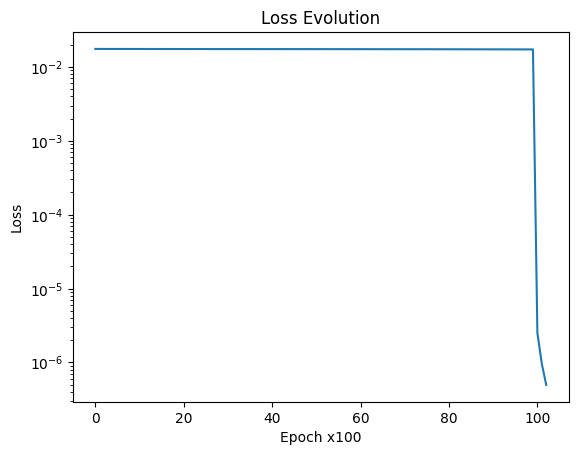

In [144]:
plt.plot(losses)
plt.yscale('log')
plt.xlabel('Epoch x100')
plt.ylabel('Loss')
plt.title('Loss Evolution')
plt.show()

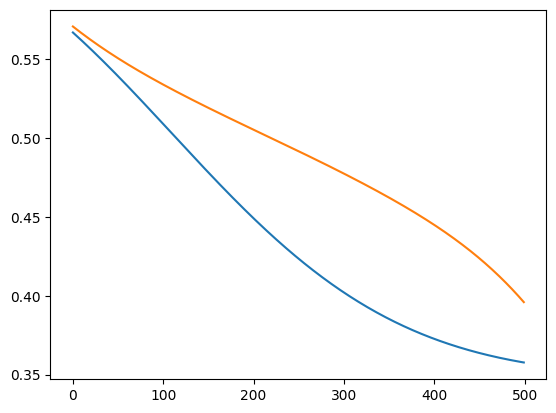

In [145]:
x_flat = jnp.linspace(0, L, 500)
outputs = jax.vmap(model)(x_flat)

plt.plot(outputs)
plt.plot(base)
#plt.ylim([0.4, .6])
plt.show()